# Rolling Resample

#### 1. Check rates in overall session, and then accounting for rearing and not-rearing *Remember to convert to binary, i.e., spike or no spike.* 

#### 2. Check small-worldness of networks during anxiety tasks, in each experiment. 

In [1]:
# Bring your packages onto the path
import os
import sys
sys.path.append(os.path.abspath(os.path.join("..", "..")))

import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pylab as plt
from analysis.sig_proc import Deconvoluter
from analysis.graph_analysis_utils import NeuronNetwork
from analysis.analysis_utils import FeatureExtractor
from IPython.core.interactiveshell import InteractiveShell

# from oasis.functions import gen_data, gen_sinusoidal_data, deconvolve, estimate_parameters
# from oasis.plotting import simpleaxis
# from oasis.oasis_methods import oasisAR1, oasisAR2

In [2]:
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

In [3]:
mouse_directory = os.path.join(os.path.expanduser("~"), "Hen_Lab/Mice/DRD87")

if not os.path.exists(mouse_directory):
    print("The mouse directory does not exist", file=sys.stderr)

file_num = 0
raw_files = list()
for dir_name, subdir_list, file_list in os.walk(mouse_directory):
    for file_name in file_list:
        if file_name.endswith(".csv"):
            print("{}. full path of: {} is: {}".format(file_num, file_name, os.path.join(dir_name, file_name)))
            file_num += 1
            raw_files.append(os.path.join(dir_name, file_name))

0. full path of: EPM_NO_OFT_POPP_cellreg_dict.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/DRD87/EPM_NO_OFT_POPP_cellreg_dict.csv
1. full path of: behavior_drd87_POPP.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/DRD87/behavior_drd87_POPP.csv
2. full path of: EPM_NO_OFT_POPP_centroids.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/DRD87/EPM_NO_OFT_POPP_centroids.csv
3. full path of: D87_POPP_C_raw.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/DRD87/D87_POPP_C_raw.csv
4. full path of: D87_OFT_C_raw.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/DRD87/D87_OFT_C_raw.csv
5. full path of: Behavior_DRD87_NO.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/DRD87/Behavior_DRD87_NO.csv
6. full path of: D87_NO_C_raw.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/DRD87/D87_NO_C_raw.csv
7. full path of: Raw_EPM2_drd87.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/DRD87/Raw_EPM2_drd87.csv
8. full path of: Behavior_DRD87_EPM.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/DRD87/Behavior_DRD87_EPM.csv


In [4]:
drd87_data = pd.read_csv(raw_files[7], header=None)
deconvoluter = Deconvoluter(drd87_data)

beh_cols = [
    "Trial_time", "Recording_time", "X_center", "Y_center", "Area", "Areachange", "Elongation", "Distance_moved", "Velocity", "Arena_centerpoint", 
    "Open1_centerpoint", "Open2_centerpoint", "Closed1_centerpoint", "Closed2_centerpoint", "OpenArms_centerpoint", "ClosedArms_centerpoint", "Result_1"
]

# Reindex neuron column vectors from 0, 1, 2, ..., n --> 1, 2, 3, ..., n, n+1
deconvoluter.cell_transients.columns = [col+1 for col in deconvoluter.cell_transients.columns]
deconvoluter.cell_auc_df.columns = [col+1 for col in deconvoluter.cell_auc_df.columns]

behavior_df = pd.read_csv(raw_files[8], header=None)
drd87_fe = FeatureExtractor(cell_transients_df=deconvoluter.cell_transients, auc_df=deconvoluter.cell_auc_df, behavior_df=behavior_df, behavior_col_names=beh_cols)

/Users/saveliyyusufov/Hen_Lab/analysis/analysis_utils.py:29: Warning:

Row multiple to downsample behavior dataframe not specified. Behavior dataframe will be downsampled by a row multiple of 3



In [5]:
drd87_fe.auc_df = drd87_fe.auc_df.where(drd87_fe.auc_df == 0, 1)

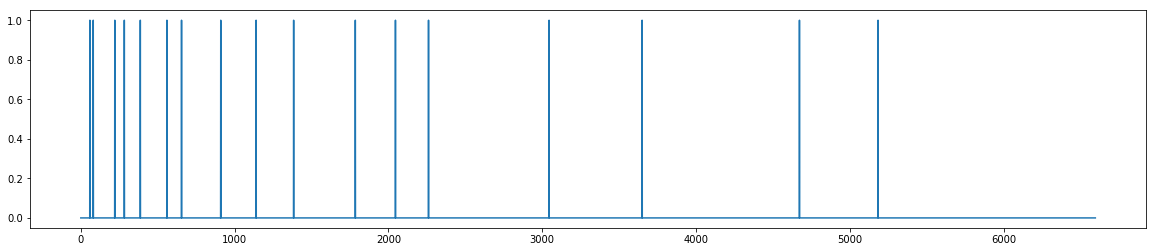

In [6]:
plt.figure(figsize=(20,4))
plt.plot(drd87_fe.auc_df[55]);

In [ ]:
def roll_worker(queue, dataframe, neuron_x, neuron_y, resamples):
    corr_coefficients = []
    high = len(dataframe.loc[:, neuron_x].index)
    
    time_series_y = dataframe.loc[:, neuron_y]
    for _ in range(resamples):
        time_series_x = np.roll(-1*dataframe.loc[:, neuron_x], shift=np.random.randint(1, high))
        corr_coefficients.append(np.corrcoef(time_series_x, time_series_y)[0][1])
    
    queue.put(corr_coefficients)

In [ ]:
from multiprocessing import Process
from multiprocessing import Queue

def roll(dataframe, neuron_x, neuron_y, resamples):
    resamples_per_worker = resamples // os.cpu_count()
    queue = Queue()
    processes = []
    rets = []
    
    for _ in range(os.cpu_count()):
        process = Process(target=roll_worker, args=(queue, dataframe, neuron_x, neuron_y, resamples_per_worker))
        processes.append(process)
        process.start()
    for process in processes:
        ret = queue.get()  # will block
        rets.append(ret)
    for process in processes:
        process.join()

    flattened_list = [item for sublist in rets for item in sublist]
        
    return flattened_list

In [ ]:
roll(drd87_fe.cell_transients_df, 1, 12, 10000)

In [ ]:
def two_sided_p_val(real_corrcoef, corr_coefficients):
    p = len(corr_coefficients)
    D = real_corrcoef
    
    count = 0
    corr_coefficients = np.abs(corr_coefficients)
    for D_i in np.abs(corr_coefficients):
        if D_i >= abs(D):
            count += 1
            
    return (1 / p) * count

In [ ]:
df = drd87_fe.cell_transients_df

for i in range(1, len(df.columns)+1):
    for j in range(i+1, len(df.columns)+1):
        real_corrcoef = np.corrcoef(df.loc[:, i], df.loc[:, j])[0][1]
        resampled_vals = roll(df, i, j, 10000)
        if two_sided_p_val(real_corrcoef, resampled_vals) < 0.01:
            print("{}, {}, r={}".format(i, j, real_corrcoef))
        else:
            print("{}, {} is not statistically significant! r={}".format(i, j, real_corrcoef))